
# 01 · Privacy Quasi-Identifier Scan (Rewired)

This notebook is the **starting point**. It scans a dataset for **direct** and **quasi-identifiers**, computes **k‑anonymity** and **l‑diversity**, and saves a JSON summary used by the rest of the workflow.

**You will get:**
- A quick schema profile and sample rows
- A list of **direct** vs **quasi-identifiers**
- **k-anonymity**, **l-diversity**, and overall **risk** score
- Visuals saved to `reports/assets/`
- `data/privacy_report.json` for downstream notebooks


In [11]:
import sys
from pathlib import Path

# Point to your repo root
repo_root = Path("/RWE-Privacy-and-Compliance-Playbook")
scripts_dir = repo_root / "scripts"
visuals_dir = repo_root / "visuals"

# Ensure packages
(scripts_dir / "__init__.py").touch()
(visuals_dir / "__init__.py").touch()

# Add repo root to Python path
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

print("Repo on path:", repo_root)
print("Has __init__.py?",
      (scripts_dir / "__init__.py").exists(),
      (visuals_dir / "__init__.py").exists())


Repo on path: /RWE-Privacy-and-Compliance-Playbook
Has __init__.py? True True


In [13]:
import os, json, pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
import sys

# ✳️ Point directly to your repo on disk
repo_root = Path("//RWE-Privacy-and-Compliance-Playbook")

# Make sure we can import project modules
scripts_dir = repo_root / "scripts"
visuals_dir = repo_root / "visuals"
for p in (scripts_dir, visuals_dir):
    if str(p) not in sys.path:
        sys.path.append(str(p))

from scripts.privacy_checks import (
    load_dataset, build_privacy_report, detect_direct_identifiers,
    detect_quasi_identifiers, k_anonymity, l_diversity, infer_column_roles
)
from visuals.privacy_plots import plot_identifier_heatmap, plot_k_equivalence_hist, save_fig

DATA_DIR = repo_root / "data"
ASSETS   = repo_root / "reports" / "assets"
DATA_DIR.mkdir(exist_ok=True, parents=True)
ASSETS.mkdir(exist_ok=True, parents=True)

# 👉 Point to your exact file
DATA_FILE = repo_root / "data" / "sample_synthetic.csv"

print("Environment ready.")
print("repo_root =", repo_root)
print("DATA_FILE =", DATA_FILE)

# Load and preview
df = load_dataset(DATA_FILE)
display(df.head())

Environment ready.
repo_root = /RWE-Privacy-and-Compliance-Playbook
DATA_FILE = s/RWE-Privacy-and-Compliance-Playbook/data/sample_synthetic.csv


,patient_id,name,email,phone,mrn,dob,birth_year,sex,race,ethnicity,...,polypharmacy_count,a1c,bp_sys,bp_dia,bp_category,site_id,payer,claim_amount,adverse_event,readmit_30d
0,6253,Riley Brown,user106252@example.com,+1-511-729-9450,MRN3665405,1982-07-04,1982,F,White,Unknown,...,1,6.6,90,90,Normal,SITE-003,Commercial,665.93,0,1
1,4685,Quinn Smith,user104684@example.com,+1-471-606-6291,MRN3280347,1970-09-11,1970,F,Unknown,Hispanic,...,0,6.5,120,79,Normal,SITE-027,Medicare,3193.06,0,0
2,1732,Avery Anderson,user101731@example.com,+1-380-269-2810,MRN8357791,1989-06-03,1989,F,Other,Hispanic,...,1,6.3,107,63,Normal,SITE-014,Commercial,1266.91,0,0
3,4743,Mia Davis,user104742@example.com,+1-501-379-4892,MRN8603402,1960-08-25,1960,F,White,Unknown,...,2,8.4,135,75,Stage1,SITE-028,Medicare,2003.40,0,0
4,4522,Jordan Davis,user104521@example.com,+1-442-868-2095,MRN5703838,1976-12-12,1976,M,White,Non-Hispanic,...,3,8.7,150,78,Stage2,SITE-036,Commercial,3034.29,0,0



## 🔧 Configure

- Place your CSV/Parquet in `data/` and set `DATA_FILE` below.  
- If not provided, we **auto‑load** `data/sample_synthetic.csv` (included).  
- Optionally set a **sensitive column** (e.g., diagnosis, outcome) to compute **l‑diversity**.


In [16]:

# Path to your dataset (CSV or Parquet). Leave as default to use the toy sample.
DATA_FILE = DATA_DIR / "sample_synthetic.csv"   # <-- change to e.g., DATA_DIR / "my_extract.csv"

# Sensitive column used for l-diversity (optional, can be None).
# Common choices: 'condition', 'diagnosis', 'outcome', 'lab_result', etc.
SENSITIVE_COL = "condition"


## 📥 Dataset generation

It generate a 10,000-row RWD-style table with direct IDs, quasi-IDs, demographics, ICD-10 conditions, meds, labs, visits, sites, and costs—plus natural skew so generalization actually changes k/l.

Direct IDs present (name, email, phone, mrn) → HIPAA Safe Harbor should flag them.

Quasi-IDs (dob, visit_date, zip5, city, state, county, sex, race, ethnicity) → meaningful k-anonymity changes when you generalize (e.g., dates→year, ZIP5→ZIP3).

Standards hints (icd10, condition labels, meds) → your OMOP/FHIR-ish checks have real columns to inspect.

Realistic skew (states, zips, conditions, payer, claims) → creates high- and low-frequency groups, so l-diversity behaves sensibly.

In [19]:
# --- Generate a richer synthetic dataset for demos ---
import numpy as np, pandas as pd
from pathlib import Path
rng = np.random.default_rng(42)

DATA_DIR = (repo_root / "data") if 'repo_root' in globals() else Path.cwd() / "data"
DATA_DIR.mkdir(parents=True, exist_ok=True)

N = 10_000  # change size here (e.g., 50_000 if you want)

# Categorical pools
states   = ["CA","TX","FL","NY","PA","IL","OH","GA","NC","MI"]
zips     = ["94110","94107","90024","02139","30303","60616","73301","10027","33612","15213","11201","27514"]
cities   = ["San Francisco","Los Angeles","Boston","Atlanta","Chicago","Austin","New York","Tampa","Pittsburgh","Brooklyn","Chapel Hill"]
counties = ["SF","LA","Middlesex","Fulton","Cook","Travis","New York","Hillsborough","Allegheny","Kings","Orange"]
sexes    = ["F","M"]
races    = ["White","Black","Asian","Other","Unknown"]
ethn     = ["Hispanic","Non-Hispanic","Unknown"]
payers   = ["Commercial","Medicare","Medicaid","Self-pay"]
sites    = [f"SITE-{i:03d}" for i in range(1, 41)]  # 40 sites

# ICD-10 (condensed)
icd10 = ["E11.9","I10","J45.909","C50.919","C34.90","I25.10","K21.9","M54.5","N18.9","F32.9"]
cond_labels = {
    "E11.9": "Type 2 Diabetes",
    "I10": "Hypertension",
    "J45.909": "Asthma",
    "C50.919": "Breast cancer",
    "C34.90": "Lung cancer",
    "I25.10": "CAD",
    "K21.9": "GERD",
    "M54.5": "Low back pain",
    "N18.9": "CKD",
    "F32.9": "Depression",
}

# Rx-like names (not RxNorm, but good for detection heuristics)
meds = ["metformin","lisinopril","atorvastatin","albuterol","omeprazole","sertraline","insulin glargine","losartan","hydrochlorothiazide","amoxicillin"]

# Skews: a few big states/zips, long-tail others
state = rng.choice(states, size=N, p=np.array([0.17,0.14,0.11,0.1,0.09,0.08,0.08,0.07,0.08,0.08]))
zip5  = rng.choice(zips,   size=N, p=np.array([0.13,0.07,0.06,0.10,0.08,0.09,0.05,0.12,0.06,0.07,0.09,0.08]))
city  = rng.choice(cities, size=N)
county= rng.choice(counties, size=N)

# Demographics
sex   = rng.choice(sexes, size=N)
race  = rng.choice(races, size=N, p=[0.55,0.14,0.07,0.14,0.10])
eth   = rng.choice(ethn,  size=N, p=[0.18,0.70,0.12])

# Ages / DOB
age = np.clip(rng.normal(58, 16, size=N).round().astype(int), 18, 95)
birth_year  = 2025 - age
birth_month = rng.integers(1, 13, size=N)
birth_day   = rng.integers(1, 29, size=N)  # avoid month-end issues
dob = pd.to_datetime(dict(year=birth_year, month=birth_month, day=birth_day))

# Visits (past ~3 years)
visit_year  = rng.choice([2022, 2023, 2024, 2025], size=N, p=[0.25,0.32,0.31,0.12])
visit_month = rng.integers(1, 13, size=N)
visit_day   = rng.integers(1, 29, size=N)
visit_date  = pd.to_datetime(dict(year=visit_year, month=visit_month, day=visit_day))

# Conditions (ICD-10) with skew to common codes
icd = rng.choice(icd10, size=N, p=np.array([0.18,0.21,0.12,0.06,0.04,0.10,0.08,0.09,0.06,0.06]))
condition = pd.Series(icd).map(cond_labels).values

# Medications: 0–3 per visit (store a main med + counts)
med_main = rng.choice(meds, size=N, p=[0.15,0.12,0.11,0.10,0.10,0.10,0.07,0.09,0.08,0.08])
polypharm = rng.integers(0, 4, size=N)

# Labs (mixed types; one numeric A1c, one categorical BP band)
a1c = np.clip(rng.normal(7.6, 1.4, size=N), 4.8, 13.5).round(1)
bp_sys = np.clip(rng.normal(132, 18, size=N), 90, 210).round().astype(int)
bp_dia = np.clip(rng.normal(82, 12, size=N), 55, 130).round().astype(int)
bp_cat = pd.cut(bp_sys, bins=[0,120,130,140,10_000], labels=["Normal","Elevated","Stage1","Stage2"])

# Sites & payer & cost
site = rng.choice(sites, size=N)
payer = rng.choice(payers, size=N, p=[0.55,0.25,0.15,0.05])
claim = np.clip(rng.gamma(shape=2.0, scale=800.0, size=N), 50, 50_000).round(2)

# Binary outcome flags
ae_flag = rng.choice([0,1], size=N, p=[0.92,0.08])
readmit_30d = rng.choice([0,1], size=N, p=[0.88,0.12])

# Direct identifiers (for HIPAA detection)
first_names = ["Alex","Jamie","Taylor","Jordan","Riley","Casey","Avery","Drew","Quinn","Kai","Noah","Emma","Liam","Olivia","Mia"]
last_names  = ["Smith","Johnson","Brown","Garcia","Miller","Davis","Martinez","Wilson","Anderson","Thomas","Lopez","Clark"]

name  = [f"{rng.choice(first_names)} {rng.choice(last_names)}" for _ in range(N)]
email = [f"user{uid}@example.com" for uid in range(100000, 100000+N)]
phone = [f"+1-{rng.integers(200,999)}-{rng.integers(200,999)}-{rng.integers(1000,9999)}" for _ in range(N)]
mrn   = [f"MRN{rng.integers(1000000, 9999999)}" for _ in range(N)]

# Assemble frame
df = pd.DataFrame({
    "patient_id": np.arange(1, N+1),
    "name": name,                        # DIRECT
    "email": email,                      # DIRECT
    "phone": phone,                      # DIRECT
    "mrn": mrn,                          # DIRECT
    "dob": dob.astype(str),              # QUASI (date)
    "birth_year": birth_year,            # helpful for generalization
    "sex": sex,
    "race": race,
    "ethnicity": eth,
    "state": state,                      # QUASI (geo)
    "city": city,                        # QUASI (geo)
    "county": county,                    # QUASI (geo)
    "zip5": zip5,                        # QUASI (geo — supports ZIP→ZIP3 generalization)
    "visit_date": visit_date.astype(str),# QUASI (date)
    "icd10": icd,                        # Standards-like
    "condition": condition,
    "med_main": med_main,
    "polypharmacy_count": polypharm,
    "a1c": a1c,
    "bp_sys": bp_sys,
    "bp_dia": bp_dia,
    "bp_category": bp_cat.astype(str),
    "site_id": site,
    "payer": payer,
    "claim_amount": claim,
    "adverse_event": ae_flag,
    "readmit_30d": readmit_30d
})

# Optional: shuffle rows to avoid obvious grouping
df = df.sample(frac=1.0, random_state=42).reset_index(drop=True)

# Save to CSV (and Parquet if you like)
out_csv = DATA_DIR / "sample_synthetic.csv"
df.to_csv(out_csv, index=False)
# df.to_parquet(DATA_DIR / "sample_synthetic.parquet", index=False)

print(f"[ok] Wrote {len(df):,} rows → {out_csv}")
df.head()

[ok] Wrote 10,000 rows → //RWE-Privacy-and-Compliance-Playbook/data/sample_synthetic.csv


,patient_id,name,email,phone,mrn,dob,birth_year,sex,race,ethnicity,...,polypharmacy_count,a1c,bp_sys,bp_dia,bp_category,site_id,payer,claim_amount,adverse_event,readmit_30d
0,6253,Riley Brown,user106252@example.com,+1-511-729-9450,MRN3665405,1982-07-04,1982,F,White,Unknown,...,1,6.6,90,90,Normal,SITE-003,Commercial,665.93,0,1
1,4685,Quinn Smith,user104684@example.com,+1-471-606-6291,MRN3280347,1970-09-11,1970,F,Unknown,Hispanic,...,0,6.5,120,79,Normal,SITE-027,Medicare,3193.06,0,0
2,1732,Avery Anderson,user101731@example.com,+1-380-269-2810,MRN8357791,1989-06-03,1989,F,Other,Hispanic,...,1,6.3,107,63,Normal,SITE-014,Commercial,1266.91,0,0
3,4743,Mia Davis,user104742@example.com,+1-501-379-4892,MRN8603402,1960-08-25,1960,F,White,Unknown,...,2,8.4,135,75,Stage1,SITE-028,Medicare,2003.40,0,0
4,4522,Jordan Davis,user104521@example.com,+1-442-868-2095,MRN5703838,1976-12-12,1976,M,White,Non-Hispanic,...,3,8.7,150,78,Stage2,SITE-036,Commercial,3034.29,0,0



## 📥 Load dataset


In [22]:

if DATA_FILE.exists():
    df = load_dataset(DATA_FILE)
    print(f"[info] Loaded dataset → {DATA_FILE}  shape={df.shape}")
else:
    print(f"[warn] {DATA_FILE} not found; creating a tiny synthetic dataframe in-memory.")
    df = pd.DataFrame({
        "patient_id": [1,2,3,4,5,6,7,8,9,10],
        "birth_date": ["1980-01-01","1979-05-12","1988-07-03","1975-09-21","1992-11-30",
                       "1981-04-10","1978-12-02","1990-01-14","1977-06-25","1985-03-17"],
        "zip_code": ["94110","94110","02139","02139","10027","10027","60616","60616","30303","30303"],
        "sex": ["F","M","F","M","F","M","F","M","F","M"],
        "condition": ["Diabetes","Hypertension","Asthma","Cancer","COPD","Diabetes","Asthma","Cancer","COPD","Hypertension"],
        "visit_date": ["2022-03-10","2022-03-10","2022-03-11","2022-03-11","2022-03-12",
                       "2022-03-12","2022-03-13","2022-03-13","2022-03-14","2022-03-14"],
        "lab_result": [7.1,"130/85","Mild","Stage II","FEV1=65%","7.4","Moderate","Stage I","FEV1=60%","140/90"]
    })
    print(f"[info] Created synthetic df shape={df.shape}")

# Keep SENSITIVE_COL only if present; else disable l-diversity
if SENSITIVE_COL not in df.columns:
    print(f"[note] Sensitive column '{SENSITIVE_COL}' not found; l-diversity will be skipped.")
    SENSITIVE_COL = None

display(df.head())


[info] Loaded dataset → /Users/cmontefusco/Coding projects/RWE-Privacy-and-Compliance-Playbook/data/sample_synthetic.csv  shape=(10000, 28)


,patient_id,name,email,phone,mrn,dob,birth_year,sex,race,ethnicity,...,polypharmacy_count,a1c,bp_sys,bp_dia,bp_category,site_id,payer,claim_amount,adverse_event,readmit_30d
0,6253,Riley Brown,user106252@example.com,+1-511-729-9450,MRN3665405,1982-07-04,1982,F,White,Unknown,...,1,6.6,90,90,Normal,SITE-003,Commercial,665.93,0,1
1,4685,Quinn Smith,user104684@example.com,+1-471-606-6291,MRN3280347,1970-09-11,1970,F,Unknown,Hispanic,...,0,6.5,120,79,Normal,SITE-027,Medicare,3193.06,0,0
2,1732,Avery Anderson,user101731@example.com,+1-380-269-2810,MRN8357791,1989-06-03,1989,F,Other,Hispanic,...,1,6.3,107,63,Normal,SITE-014,Commercial,1266.91,0,0
3,4743,Mia Davis,user104742@example.com,+1-501-379-4892,MRN8603402,1960-08-25,1960,F,White,Unknown,...,2,8.4,135,75,Stage1,SITE-028,Medicare,2003.40,0,0
4,4522,Jordan Davis,user104521@example.com,+1-442-868-2095,MRN5703838,1976-12-12,1976,M,White,Non-Hispanic,...,3,8.7,150,78,Stage2,SITE-036,Commercial,3034.29,0,0



## 🧭 Schema quick‑look


In [25]:

print("Columns:", list(df.columns))
print("Shape:", df.shape)
display(df.describe(include='all').T.head(20))

roles = infer_column_roles(df)
print("\nInferred roles:")
for k,v in roles.items():
    print(f"  - {k}: {v}")


Columns: ['patient_id', 'name', 'email', 'phone', 'mrn', 'dob', 'birth_year', 'sex', 'race', 'ethnicity', 'state', 'city', 'county', 'zip5', 'visit_date', 'icd10', 'condition', 'med_main', 'polypharmacy_count', 'a1c', 'bp_sys', 'bp_dia', 'bp_category', 'site_id', 'payer', 'claim_amount', 'adverse_event', 'readmit_30d']
Shape: (10000, 28)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
patient_id,10000.0,NaN,NaN,NaN,5000.5,2886.89568,1.0,2500.75,5000.5,7500.25,10000.0
name,10000,180,Olivia Wilson,77,NaN,NaN,NaN,NaN,NaN,NaN,NaN
email,10000,10000,user106252@example.com,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
phone,10000,10000,+1-511-729-9450,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mrn,10000,9994,MRN9981447,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dob,10000,7812,1963-06-10,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
birth_year,10000.0,NaN,NaN,NaN,1967.1242,15.830105,1930.0,1956.0,1967.0,1978.0,2007.0
sex,10000,2,F,5024,NaN,NaN,NaN,NaN,NaN,NaN,NaN
race,10000,5,White,5423,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ethnicity,10000,3,Non-Hispanic,7067,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Inferred roles:
  - id_cols: ['patient_id', 'name', 'email', 'phone', 'mrn', 'site_id']
  - date_cols: ['dob', 'birth_year', 'visit_date']
  - numeric_cols: ['patient_id', 'birth_year', 'zip5', 'polypharmacy_count', 'a1c', 'bp_sys', 'bp_dia', 'claim_amount', 'adverse_event', 'readmit_30d']
  - categorical_cols: ['name', 'email', 'phone', 'mrn', 'dob', 'sex', 'race', 'ethnicity', 'state', 'city', 'county', 'visit_date', 'icd10', 'condition', 'med_main', 'bp_category', 'site_id', 'payer']



## 🔎 Identifier scan
Detect **direct identifiers** (e.g., names, MRN, email) and **quasi-identifiers** (dates, ZIP, small‑area geos, demographics).


In [28]:

direct = detect_direct_identifiers(df)
quasi  = detect_quasi_identifiers(df)

print("Direct identifiers:", sorted(direct) if direct else "None")
print("Quasi-identifiers :", sorted(quasi) if quasi else "None")


Direct identifiers: ['email', 'mrn', 'name', 'phone']
Quasi-identifiers : ['birth_year', 'bp_category', 'city', 'condition', 'county', 'dob', 'ethnicity', 'icd10', 'med_main', 'payer', 'race', 'sex', 'site_id', 'state', 'visit_date', 'zip5']



## 📏 Privacy metrics
Compute **k‑anonymity** and **l‑diversity** (if sensitive column provided). The full report is saved for later steps.


In [31]:

k_val = k_anonymity(df, quasi)
l_val = l_diversity(df, quasi, SENSITIVE_COL, method="distinct") if SENSITIVE_COL else np.nan

report = build_privacy_report(
    df,
    sensitive_col=SENSITIVE_COL,
    quasi_override=sorted(quasi) if quasi else None
)

# Save JSON
privacy_json = DATA_DIR / "privacy_report.json"
privacy_json.write_text(json.dumps(report, indent=2))
print(f"[ok] Wrote → {privacy_json}")

pd.DataFrame([{
    "k_anonymity": k_val,
    "l_diversity": l_val if not pd.isna(l_val) else None,
    "direct_identifiers": ", ".join(sorted(direct)) if direct else "None",
    "quasi_identifiers": ", ".join(sorted(quasi)) if quasi else "None"
}])


[ok] Wrote → /Users/cmontefusco/Coding projects/RWE-Privacy-and-Compliance-Playbook/data/privacy_report.json


,k_anonymity,l_diversity,direct_identifiers,quasi_identifiers
0,1,1.0,"email, mrn, name, phone","birth_year, bp_category, city, condition, coun..."



## 📈 Visuals
We save charts into `reports/assets/` for embedding in the final PDF.


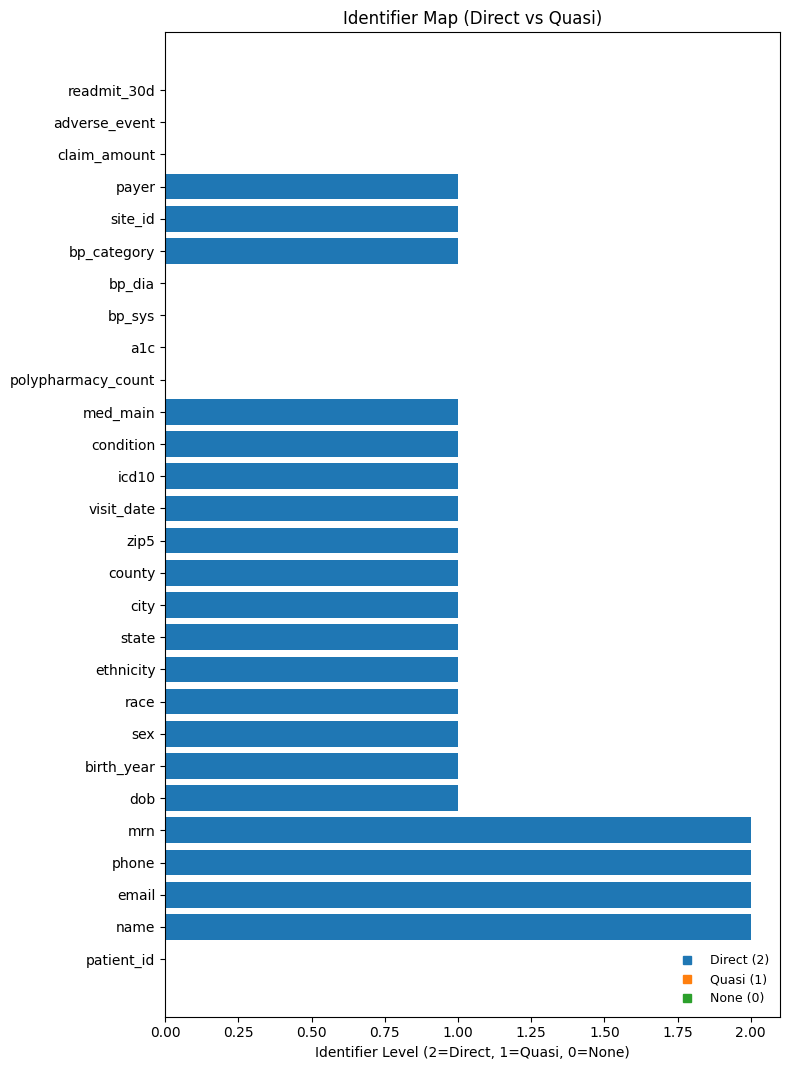

[ok] saved: /Users/cmontefusco/Coding projects/RWE-Privacy-and-Compliance-Playbook/reports/assets/identifier_map.png


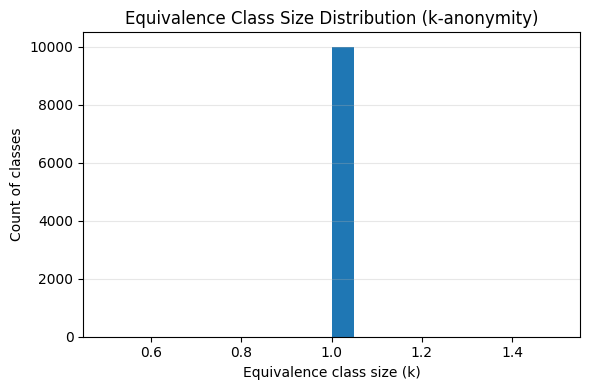

[ok] saved: /RWE-Privacy-and-Compliance-Playbook/reports/assets/k_hist.png


In [34]:

# Identifier map (direct vs quasi)
fig1 = plot_identifier_heatmap(df.columns, direct, quasi)
p1 = save_fig(fig1, ASSETS / "identifier_map.png")
plt.show(); print("[ok] saved:", p1)

# k-anonymity equivalence class histogram
fig2 = plot_k_equivalence_hist(df, quasi)
p2 = save_fig(fig2, ASSETS / "k_hist.png")
plt.show(); print("[ok] saved:", p2)



## ✅ What to do next

- If **direct identifiers** were detected → drop or replace them before sharing data.  
- If **k < 5** or **l < 2**, increase generalization (dates → year/month, ZIP → ZIP3, bucket rare categories).  
- Continue to **02_deidentification_scorecard.ipynb** to apply generalizations and compare **before → after**.  
- `privacy_report.json` you just created will be used by **03 (Compliance)** and **04 (ROI + Report)**.
